# [玉山人工智慧公開挑戰賽2019秋季賽,真相只有一個 -『信用卡盜刷偵測』](https://tbrain.trendmicro.com.tw/Competitions/Details/10)

## <font color=red>任務:預測某刷卡交易是否為盜刷</font>

### Task Schedule:
1. 讀取資料,將字串轉換成int
2. EDA(exploratory data analysis)
3. Feature engineering
4. 訓練模型,調整參數(預計使用lgb，速度較快)
5. 嘗試使用不同模型,做Ensamble(blending, stacking)
6. Anomaly detection

### 注意事項:
1. 因為test data和train data時間不相關,在驗證時採取前60天訓練61~90天驗證,但仍需小心時間差異造成的影響

### TODO:
1. **EDA(見下方詳細解釋）,找出不適合作為training feature的特徵,加以轉化成高級特徵或刪除**
2. **找data leakage**

3. Anomaly detection: 看這類的模型能不能取代lgb(似乎是不行，盜刷數據並沒有那麼Anomaly）,但可以嘗試將Anomaly結果當成新feature

### <font color=green>Results:</font>
* 不做處理,直接丟lgb訓練 leaderboard score:0.45


## 讀取,轉換字串成可以訓練的資料

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import math

%matplotlib inline
data_path = '../data'

random_seed = 2000

In [2]:
data_list=['raw_data.csv','FE_data1.csv','FE_data2.csv','FE_data4.csv']

data=[]
for d in data_list:
    x = pd.read_csv('../data/preprocess/{}'.format(d),index_col=False)
    print(d,x.shape)
    x_null = x.isnull().sum()
    print("Null columns:\n",x_null[x_null>0])
    
    if (d=='FE_data1.csv') or (d=='FE_data2.csv'):
        x=x.fillna(value=-1)
        
    data.append(x)

all_data = pd.concat(data,axis=1)

all_data_numsum = all_data.isnull().sum()
print('ALL data null:')
print(all_data_numsum[all_data_numsum>0])

raw_data.csv (1943452, 23)
Null columns:
 fraud_ind    421665
dtype: int64
FE_data1.csv (1943452, 54)
Null columns:
 cano_conam_skew       93942
cano_conam_kurt      156402
cano_conam_var        39970
bacno_locdt_skew      60927
bacno_locdt_kurt     104832
cano_locdt_skew       93942
cano_locdt_kurt      156402
mchno_fraud_mean    1204852
mcc_fraud_mean      1680560
acqic_fraud_mean    1643540
dtype: int64
FE_data2.csv (1943452, 8)
Null columns:
 Series([], dtype: int64)
FE_data4.csv (1943452, 6)
Null columns:
 Series([], dtype: int64)
ALL data null:
fraud_ind    421665
dtype: int64


In [12]:
bool_cols = all_data.columns[all_data.dtypes==bool].values
for b in bool_cols:
    all_data[b] = all_data[b].map({True:1,False:0}) 

## EDA(觀察資料分佈, 找特徵工程的Idea）

#### 方法（四種）:
1. 比較train, validation data, test data各個feature(不包括fraud_ind)的分佈，看各個feature是否會隨時間不同而改變
    * 見 function compare_distribution
    * 檢查差異,目測結果: txkey有一點差異，其他幾乎一樣
    

2. 比較train, validation data各個feature相對於fraud_ind的關係，看他們與fraud_ind的關係是否會隨時間改變，如果會就不適合做training feature
    * 見 function analze_distribution
    * 檢查差異，目測結果:
        * 明顯差異,應該去除,或應該抽取更高層的穩定特徵(TODO): csmcu,mcc,loctm_hr2
        * 無法判讀:應該找出來並想辦法去除或找更高層特徵(TODO): 蠻多特徵都看不出來有沒有差,因為類別太多＝＝


3. 比較normal, fraud data的各個feature分佈差異，找有問題的feature!
    * 結果:


4. 但這樣無法看出單一用戶在normal和fraud的關係，所以要另外印出檢查，看有fraud data的用戶，該資料特點在哪
    * 根據時間順序,以每個bacno來看fraud情況(最重要,適合找data leakage!!!!)
    

## 觀測 train, validation, test的distribution
* 跟fraud_ind相關的，檢查train和validation就好（假設test data跟validation類似）
* 每筆feature的distribution，檢查train,validation和test


In [13]:
def analze_distribution(data, target_col, feature, data_test):
#     if data[feature].nunique()!=data_test[feature].nunique():
#         print('data nunique not the same')
    print(feature)
    plt.clf()
    mean_data = data.groupby(feature)[target_col].mean()
    mean_data_test = data_test.groupby(feature)[target_col].mean()
    distribution_data = data[feature].value_counts(dropna=False)
    distribution_data_test = data_test[feature].value_counts(dropna=False)
    
    fig, axs = plt.subplots(2,2,figsize=(10,5))
    axs[0,0].plot(mean_data.index, mean_data.values, marker='o')
    axs[0,0].set_title('Average {} wrt {}'.format(target_col,feature))
    axs[0,0].set_ylabel('mean of {}'.format(target_col))
    axs[0,0].set_xlabel(feature)
    
    
    bins = data[feature].nunique() if data[feature].nunique()<100 else 100
    data[feature].hist(bins=bins,ax=axs[0,1])

#     axs[0,1].bar(distribution_data.index, distribution_data.values, alpha=0.5)
    axs[0,1].set_title('distribution of {}'.format(feature))
    axs[0,1].set_ylabel('count of {}'.format(feature))
    axs[0,1].set_xlabel(feature)
    
    # Add text in figure coordinates
    plt.figtext(0.5, 1,   'Train data plot', ha='center', va='center', fontsize=15)
    plt.figtext(0.5, 0.5, 'Test data plot', ha='center', va='center', fontsize=15)
    axs[1,0].plot(mean_data_test.index, mean_data_test.values, marker='o')
    axs[1,0].set_title('Average {} wrt {}'.format(target_col,feature))
    axs[1,0].set_ylabel('mean of {}'.format(target_col))
    axs[1,0].set_xlabel(feature)
    
    bins = data_test[feature].nunique() if data_test[feature].nunique()<100 else 100
    data_test[feature].hist(bins=bins,ax=axs[1,1])
#     axs[1,1].bar(distribution_data_test.index, distribution_data_test.values, alpha=0.5)
    distribution_data_test.hist
    axs[1,1].set_title('distribution of {}'.format(feature))
    axs[1,1].set_ylabel('count of {}'.format(feature))
    axs[1,1].set_xlabel(feature)
    plt.tight_layout(pad=3)
    plt.show()

acqic


<Figure size 432x288 with 0 Axes>

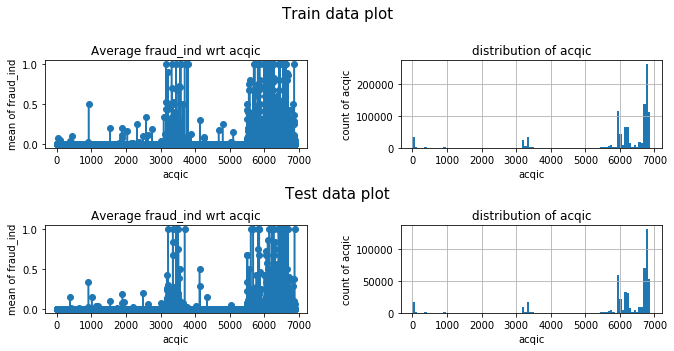

bacno


<Figure size 432x288 with 0 Axes>

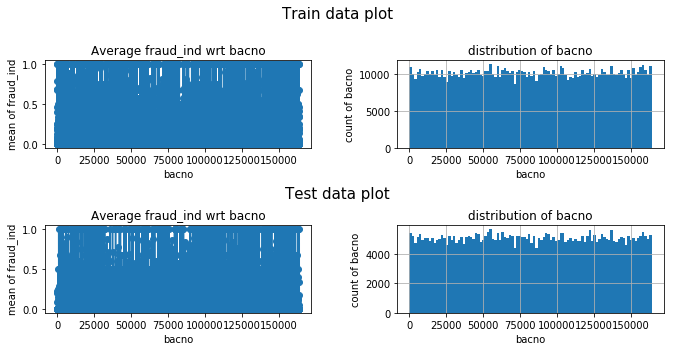

cano


<Figure size 432x288 with 0 Axes>

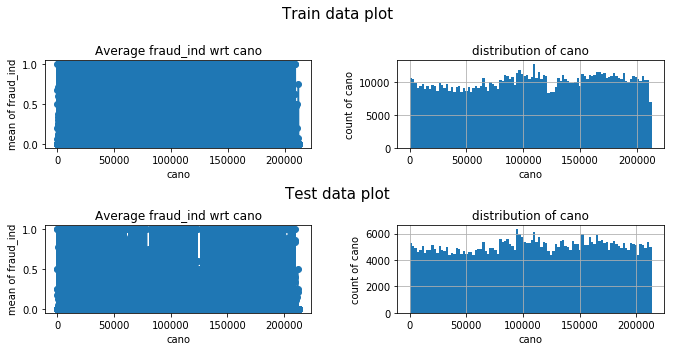

conam


<Figure size 432x288 with 0 Axes>

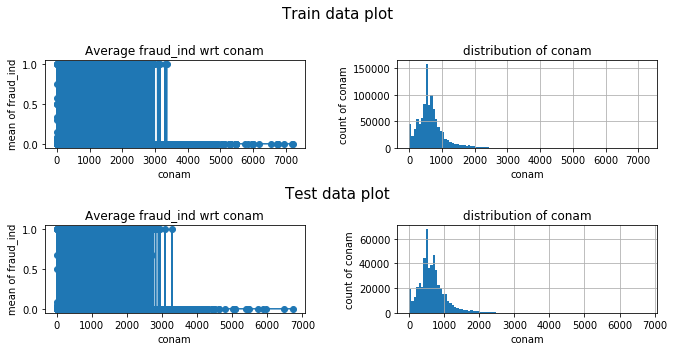

contp


<Figure size 432x288 with 0 Axes>

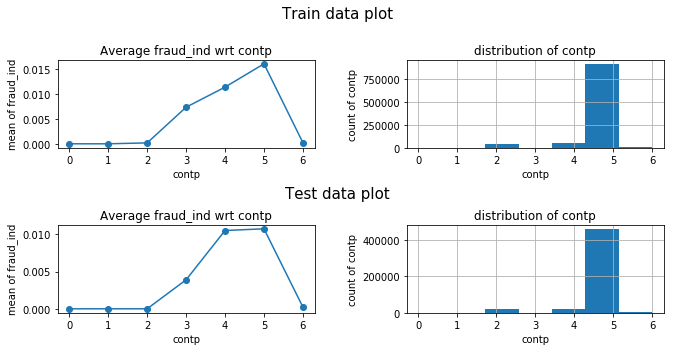

csmcu


<Figure size 432x288 with 0 Axes>

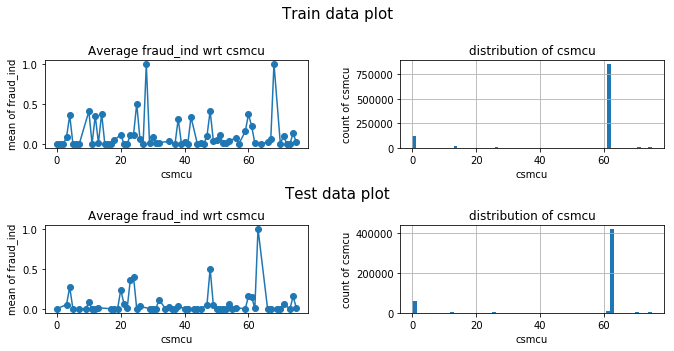

ecfg


<Figure size 432x288 with 0 Axes>

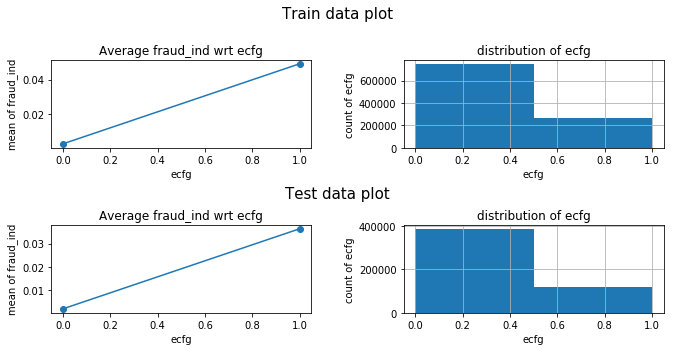

etymd


<Figure size 432x288 with 0 Axes>

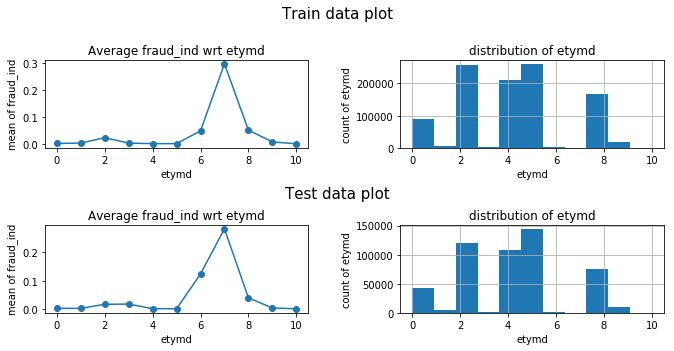

flbmk


<Figure size 432x288 with 0 Axes>

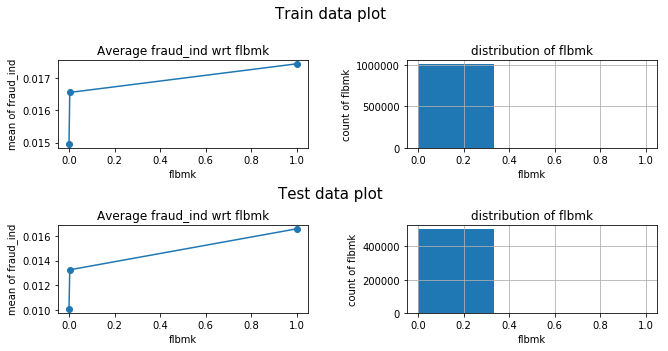

flg_3dsmk


<Figure size 432x288 with 0 Axes>

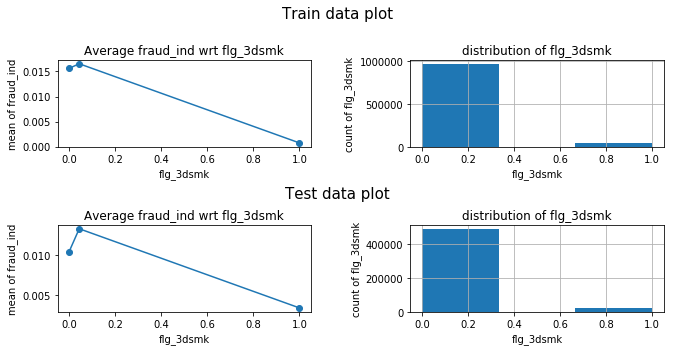

fraud_ind


<Figure size 432x288 with 0 Axes>

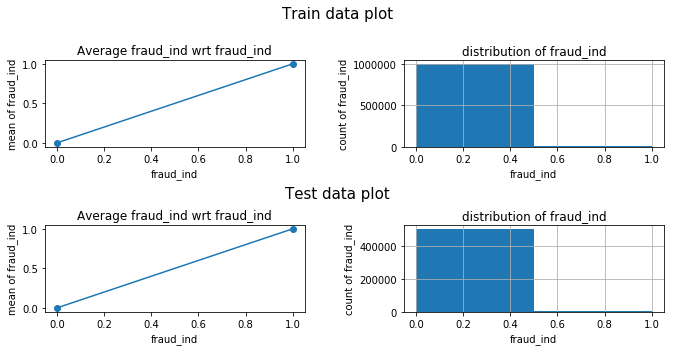

hcefg


<Figure size 432x288 with 0 Axes>

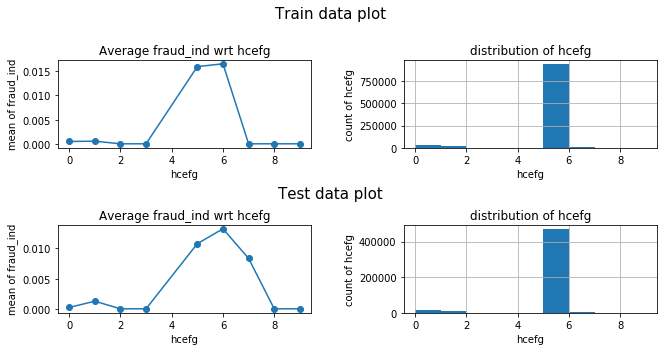

insfg


<Figure size 432x288 with 0 Axes>

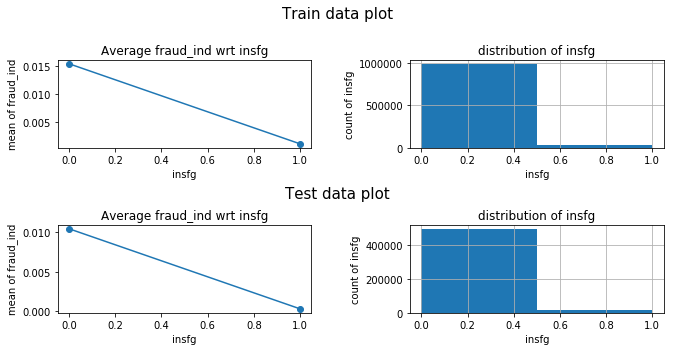

iterm


<Figure size 432x288 with 0 Axes>

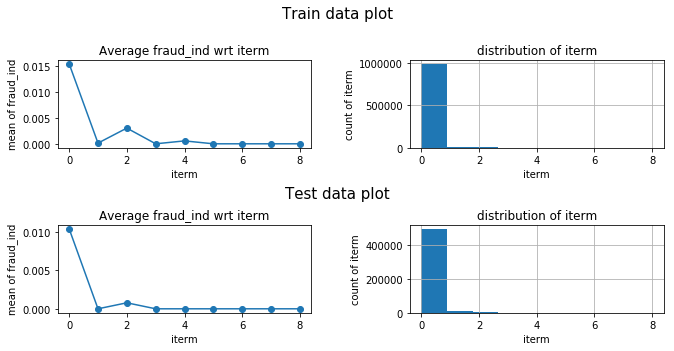

locdt


<Figure size 432x288 with 0 Axes>

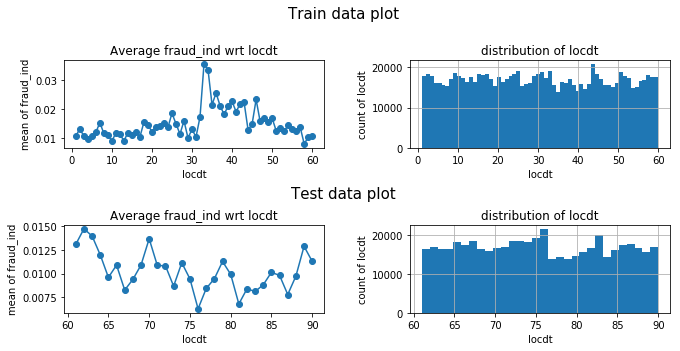

loctm


<Figure size 432x288 with 0 Axes>

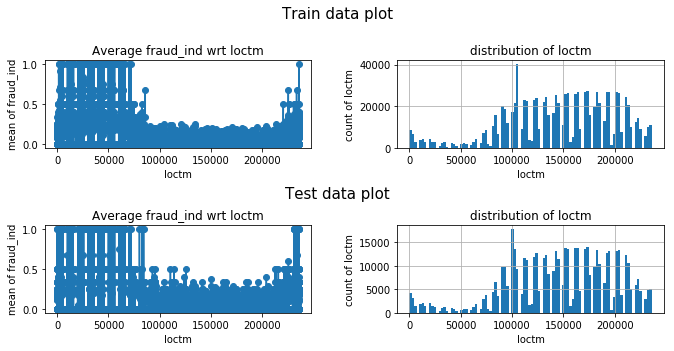

mcc


<Figure size 432x288 with 0 Axes>

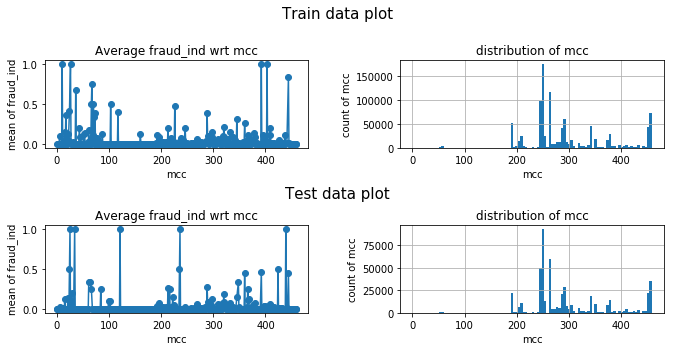

mchno


<Figure size 432x288 with 0 Axes>

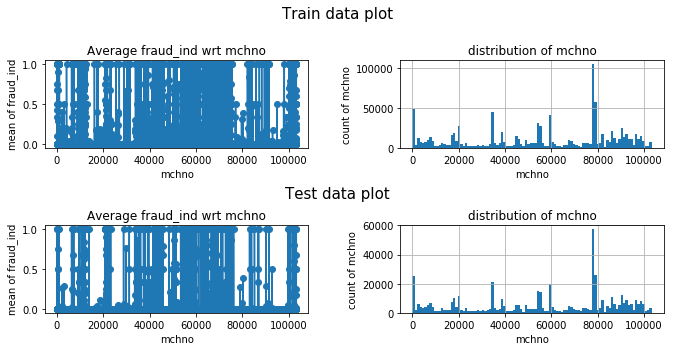

ovrlt


<Figure size 432x288 with 0 Axes>

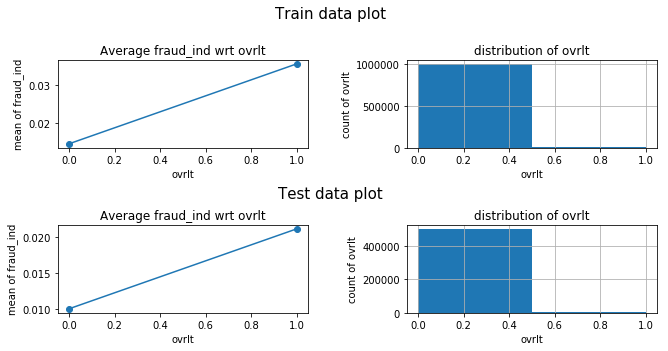

scity


<Figure size 432x288 with 0 Axes>

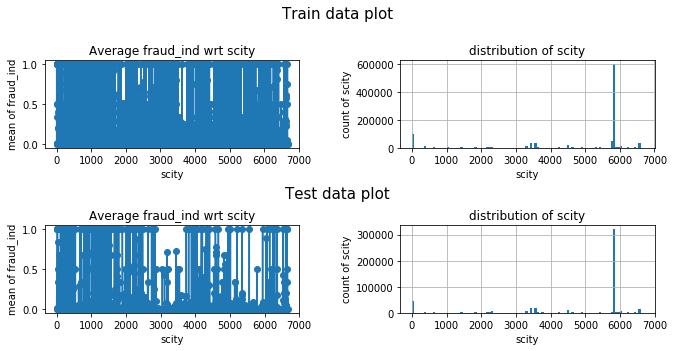

stocn


<Figure size 432x288 with 0 Axes>

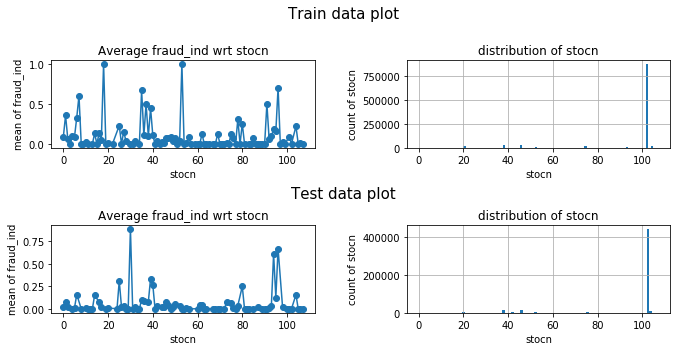

stscd


<Figure size 432x288 with 0 Axes>

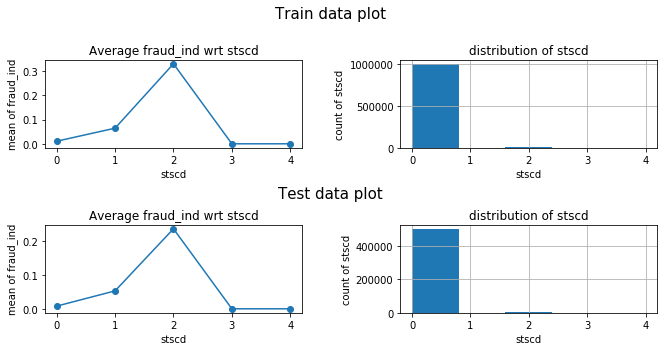

txkey


<Figure size 432x288 with 0 Axes>

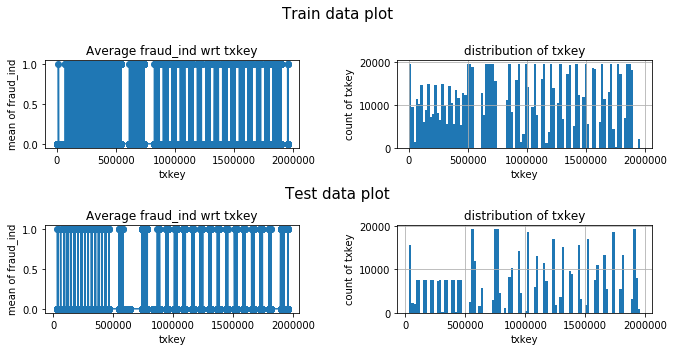

stocn_bin


<Figure size 432x288 with 0 Axes>

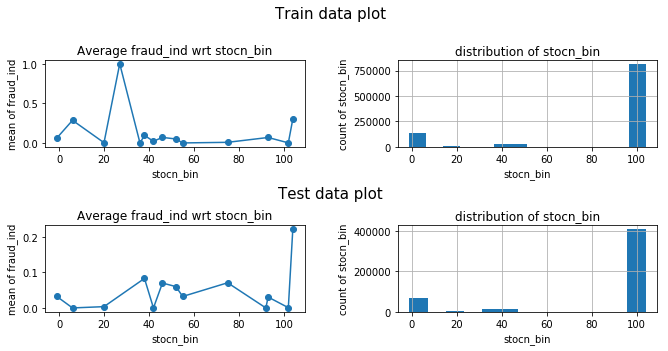

scity_bin


<Figure size 432x288 with 0 Axes>

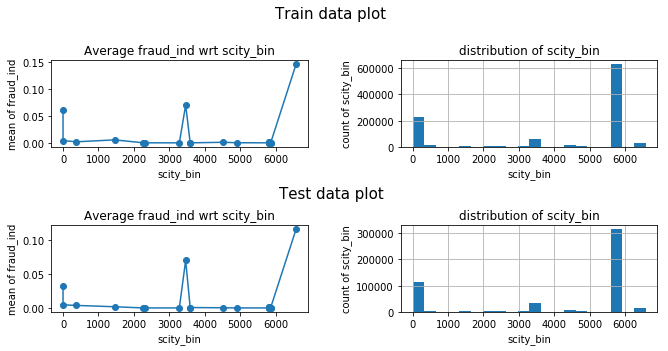

csmcu_bin


<Figure size 432x288 with 0 Axes>

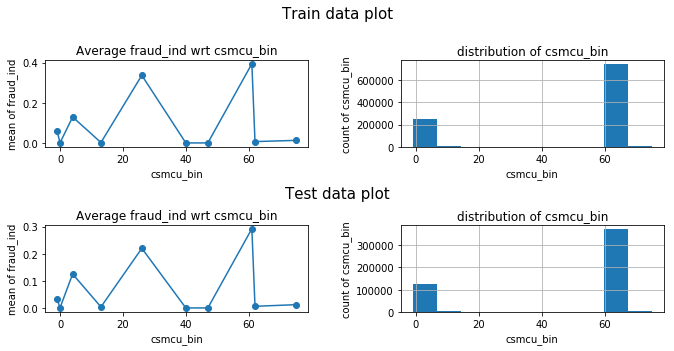

txkey_bin


<Figure size 432x288 with 0 Axes>

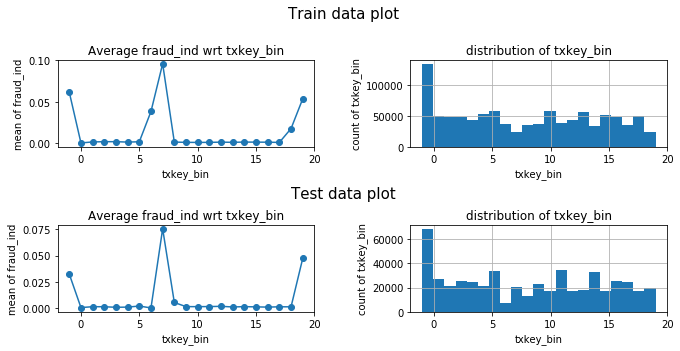

bacno_cano_not1


<Figure size 432x288 with 0 Axes>

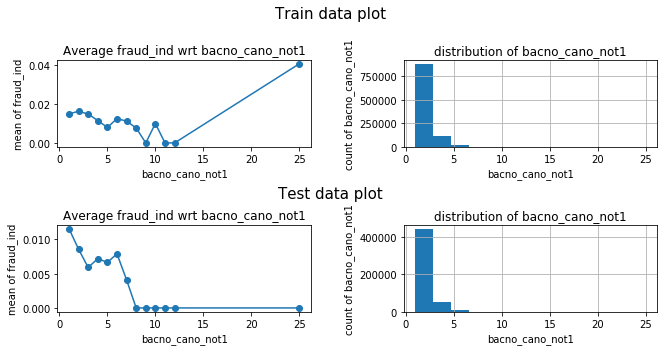

bacno_txkey_count


<Figure size 432x288 with 0 Axes>

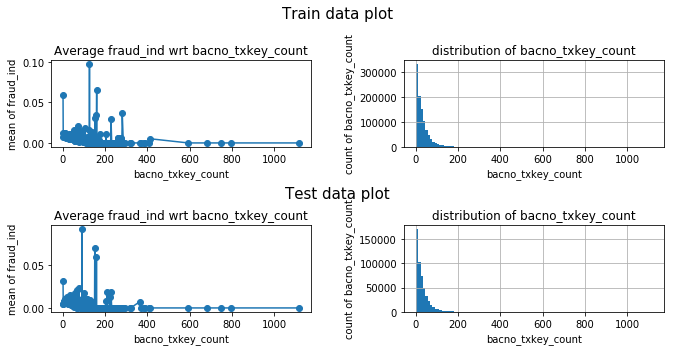

conam_log


<Figure size 432x288 with 0 Axes>

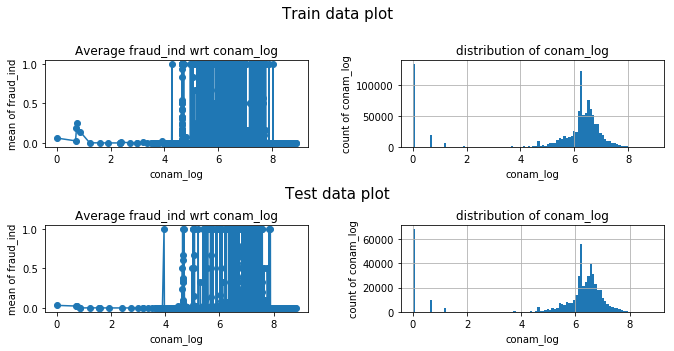

bacno_mean_conam


<Figure size 432x288 with 0 Axes>

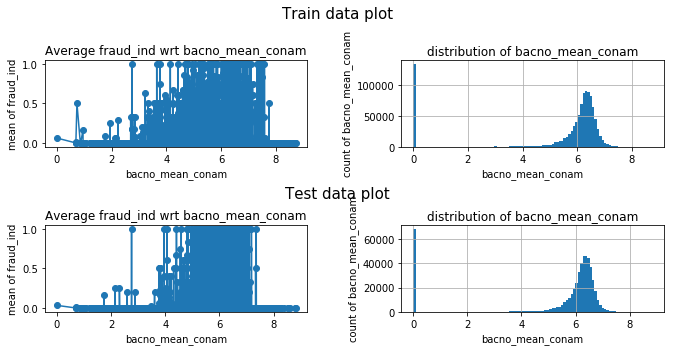

bacno_scale_conam


<Figure size 432x288 with 0 Axes>

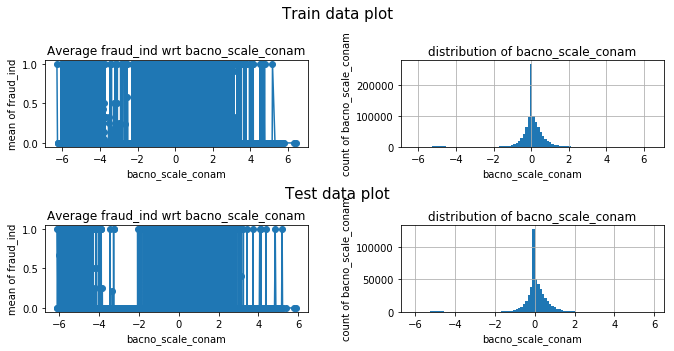

cano_mean_conam


<Figure size 432x288 with 0 Axes>

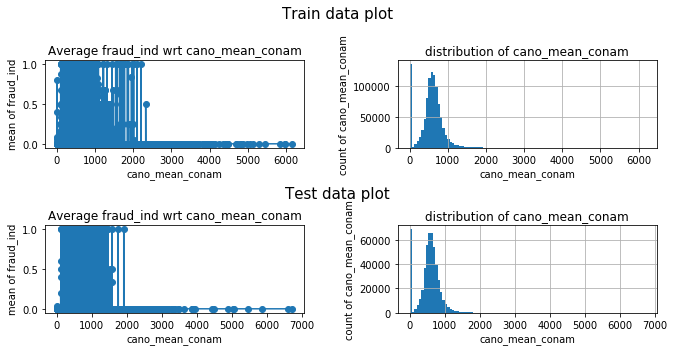

cano_scale_conam


<Figure size 432x288 with 0 Axes>

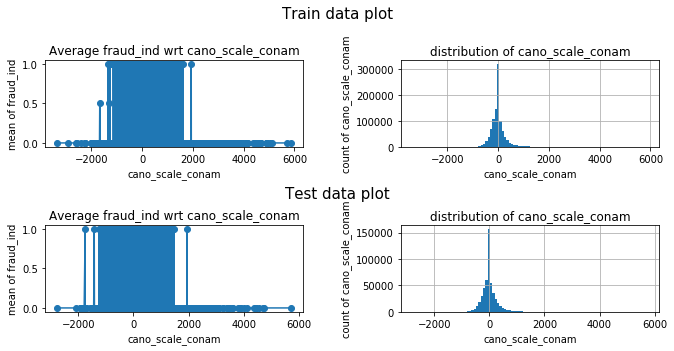

cano_conam_skew


<Figure size 432x288 with 0 Axes>

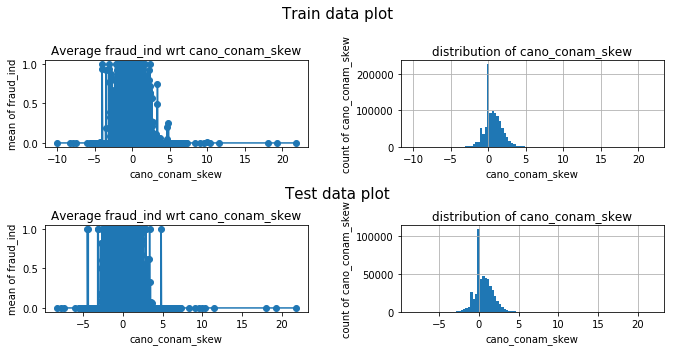

cano_conam_kurt


<Figure size 432x288 with 0 Axes>

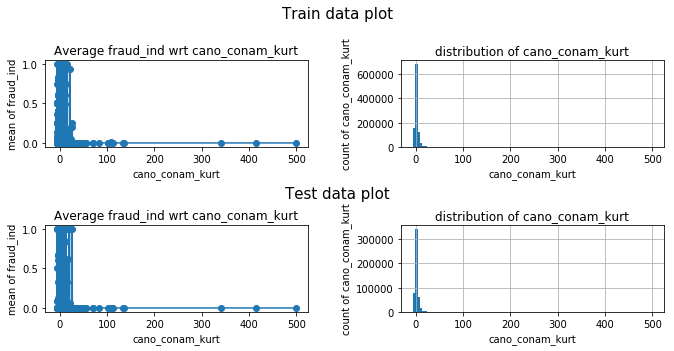

cano_conam_mean


<Figure size 432x288 with 0 Axes>

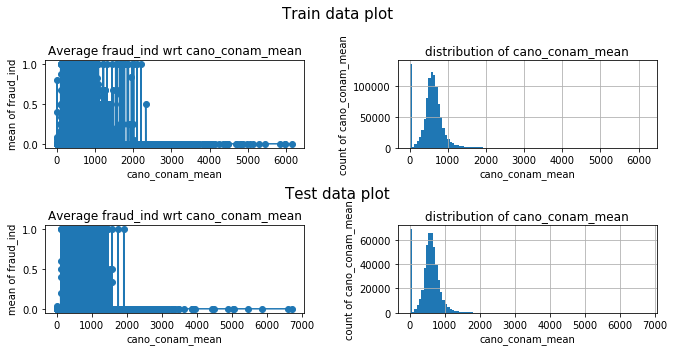

cano_conam_var


<Figure size 432x288 with 0 Axes>

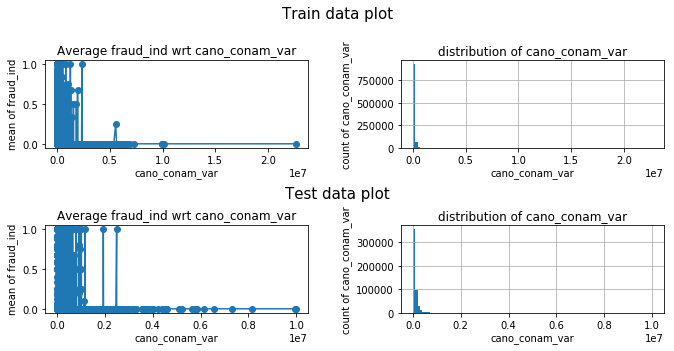

bacno_max_conam


<Figure size 432x288 with 0 Axes>

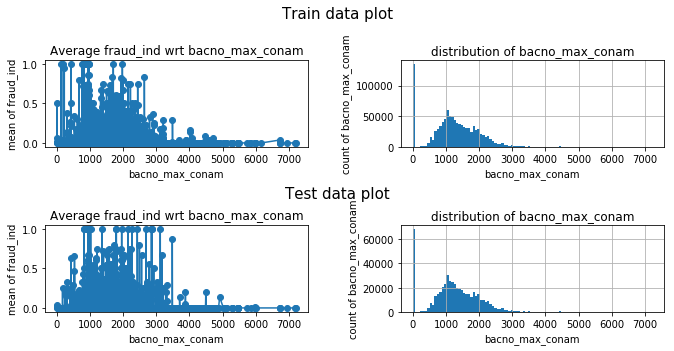

bacno_ismax_conam


<Figure size 432x288 with 0 Axes>

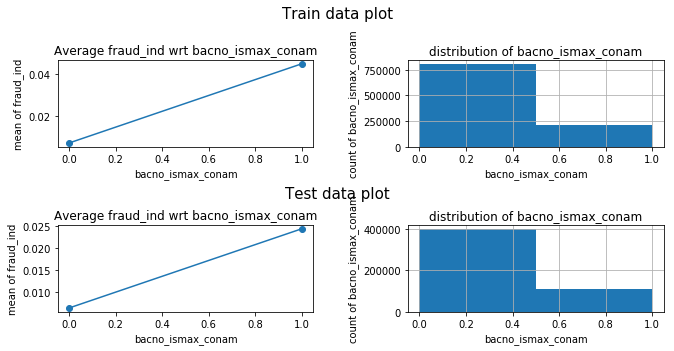

bacno_min_conam


<Figure size 432x288 with 0 Axes>

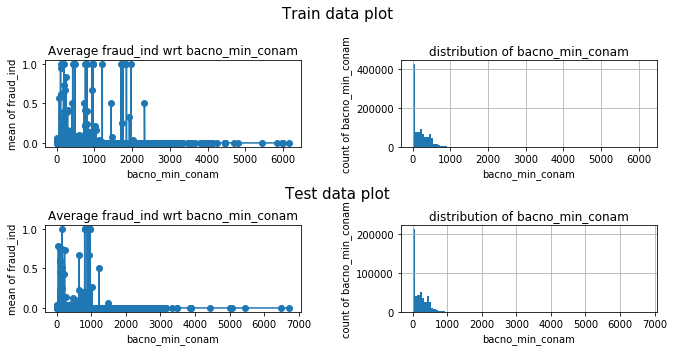

bacno_ismin_conam


<Figure size 432x288 with 0 Axes>

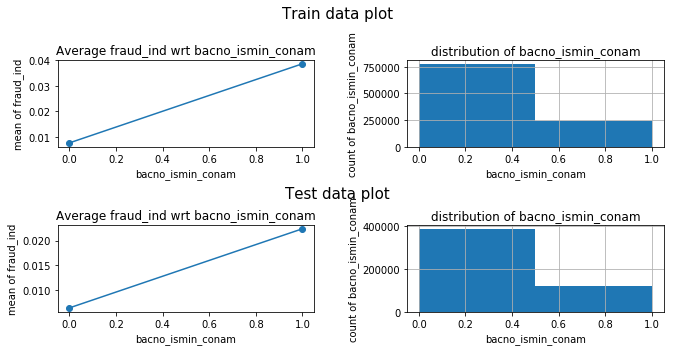

bacno_ratio_ecfg


<Figure size 432x288 with 0 Axes>

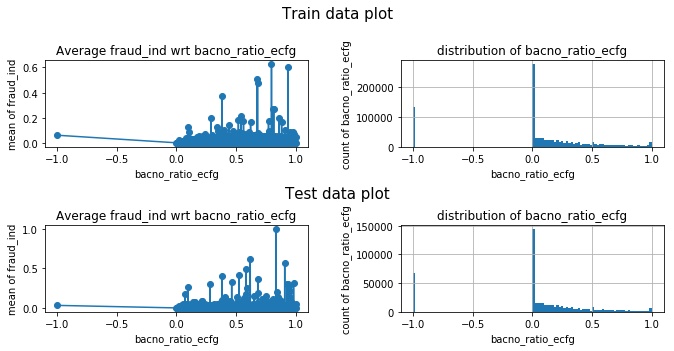

cano_ratio_ecfg


<Figure size 432x288 with 0 Axes>

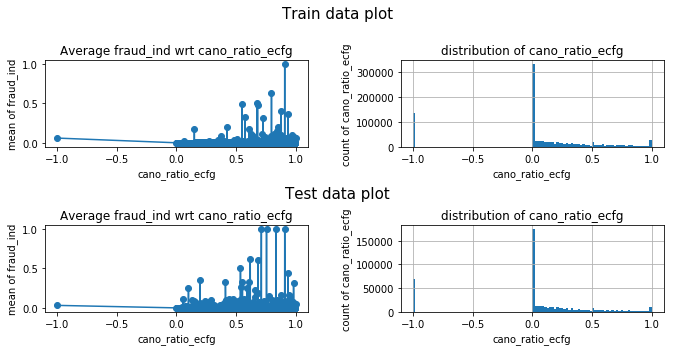

locdt_week


<Figure size 432x288 with 0 Axes>

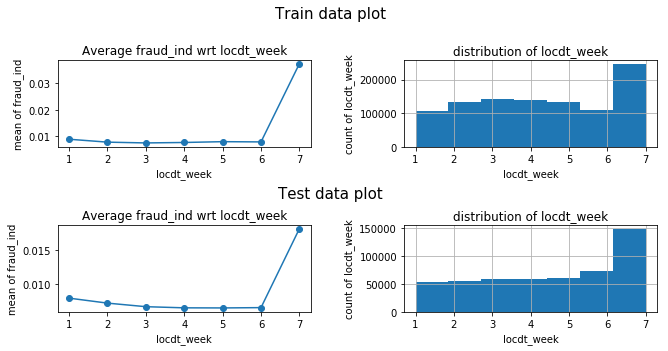

loctm_hr


<Figure size 432x288 with 0 Axes>

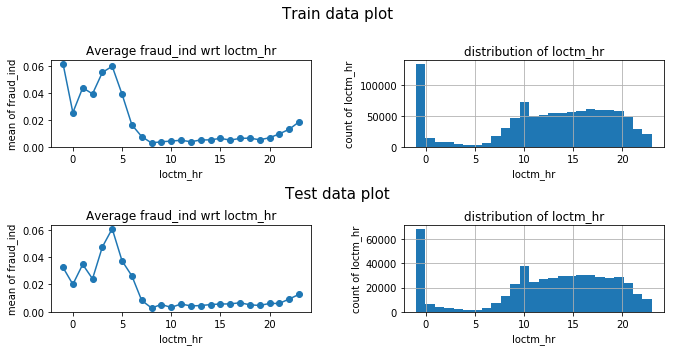

bacno_locdt_skew


<Figure size 432x288 with 0 Axes>

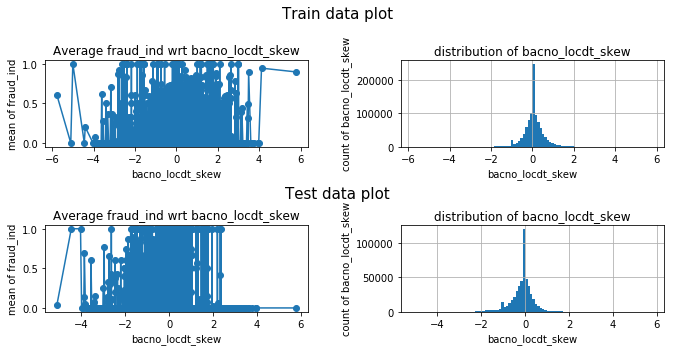

bacno_locdt_kurt


<Figure size 432x288 with 0 Axes>

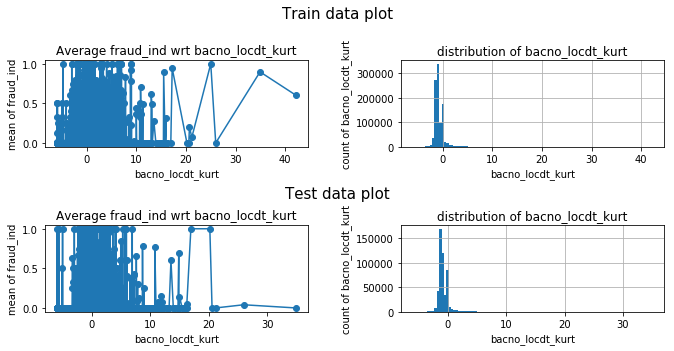

cano_locdt_skew


<Figure size 432x288 with 0 Axes>

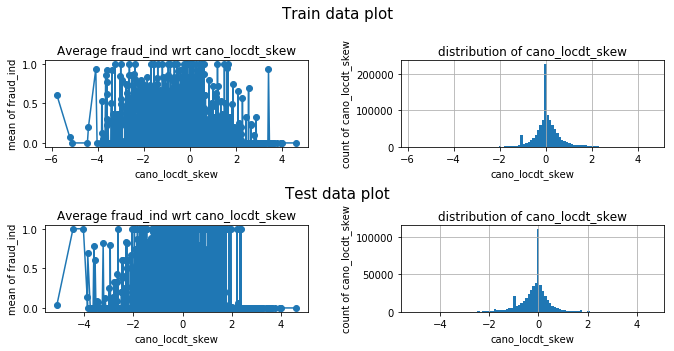

cano_locdt_kurt


<Figure size 432x288 with 0 Axes>

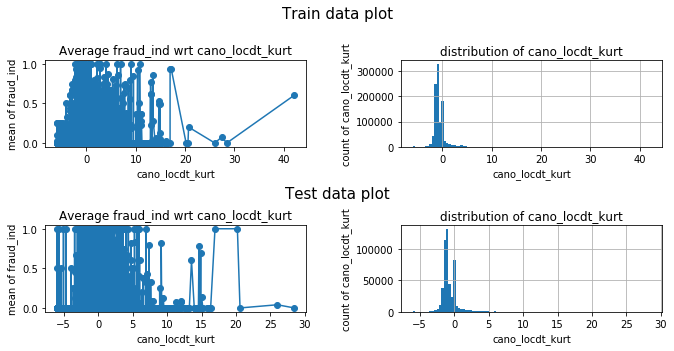

bacno_stocn_mode


<Figure size 432x288 with 0 Axes>

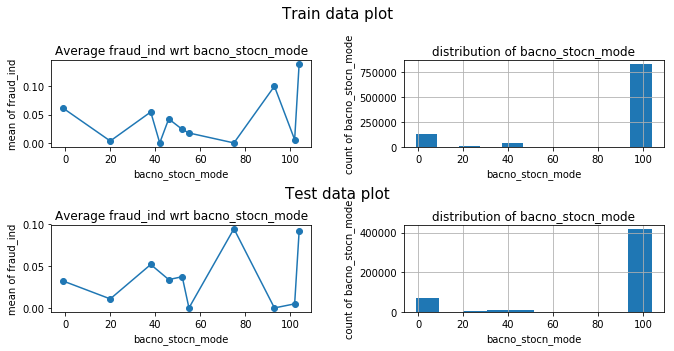

bacno_scity_mode


<Figure size 432x288 with 0 Axes>

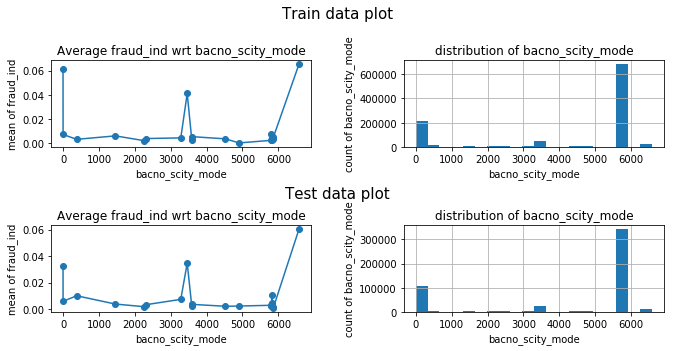

bacno_csmcu_mode


<Figure size 432x288 with 0 Axes>

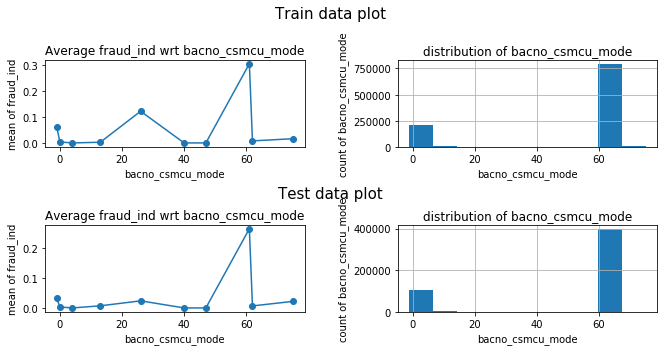

bacno_stocn_ismode


<Figure size 432x288 with 0 Axes>

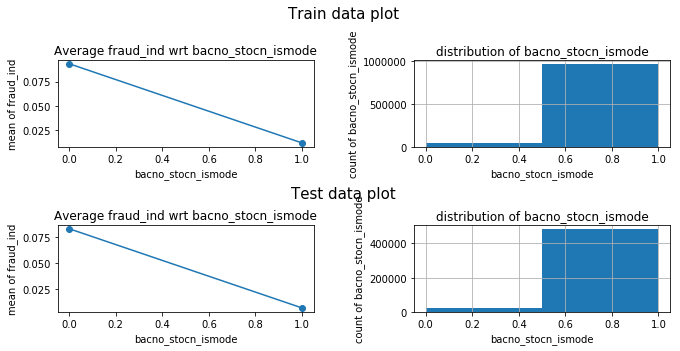

bacno_scity_ismode


<Figure size 432x288 with 0 Axes>

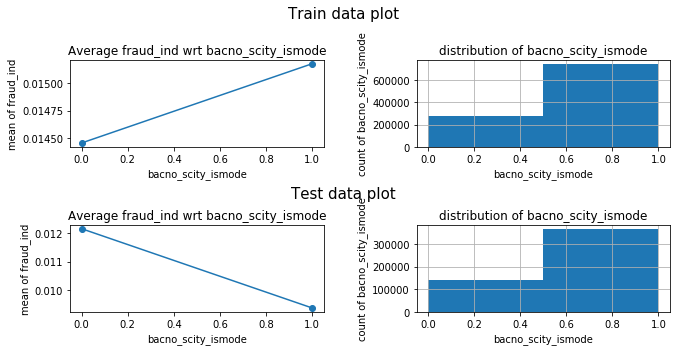

bacno_csmcu_ismode


<Figure size 432x288 with 0 Axes>

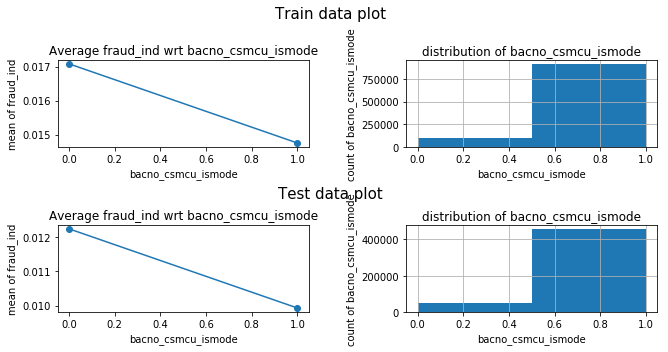

cano_stocn_mode


<Figure size 432x288 with 0 Axes>

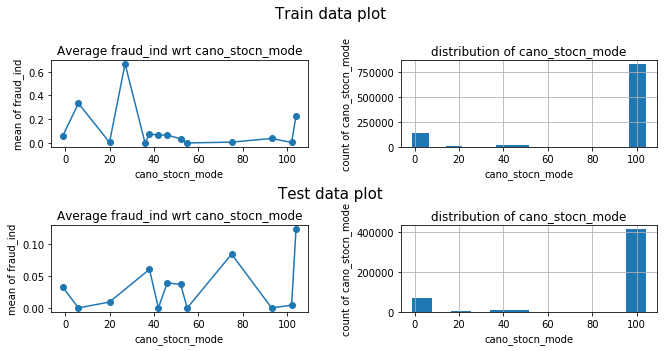

cano_scity_mode


<Figure size 432x288 with 0 Axes>

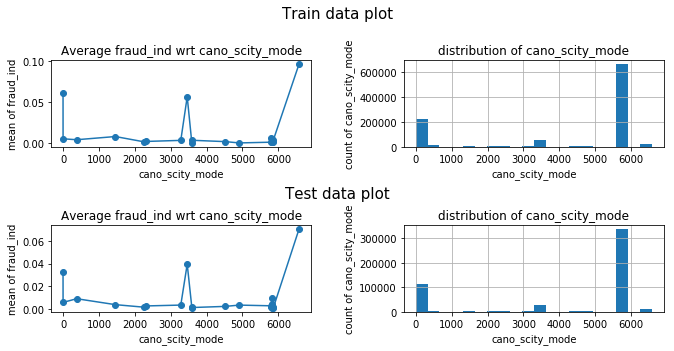

cano_csmcu_mode


<Figure size 432x288 with 0 Axes>

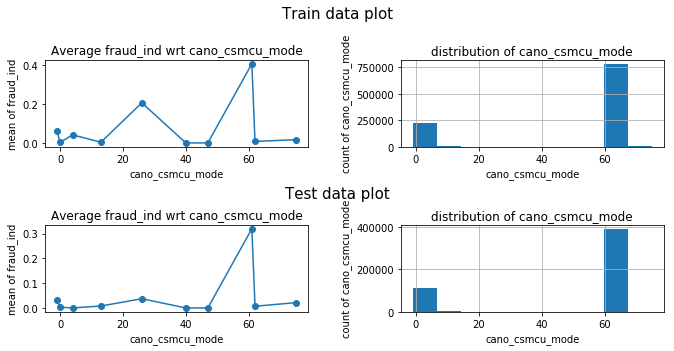

cano_stocn_ismode


<Figure size 432x288 with 0 Axes>

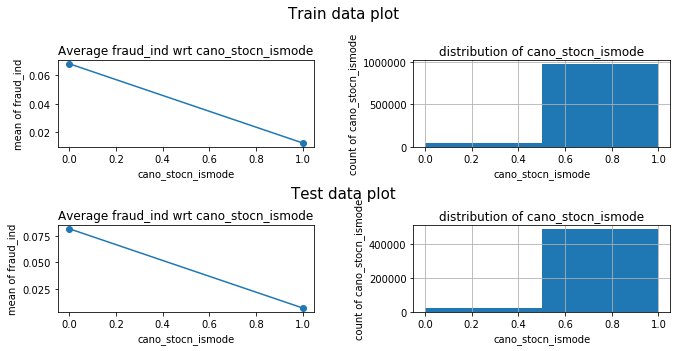

cano_scity_ismode


<Figure size 432x288 with 0 Axes>

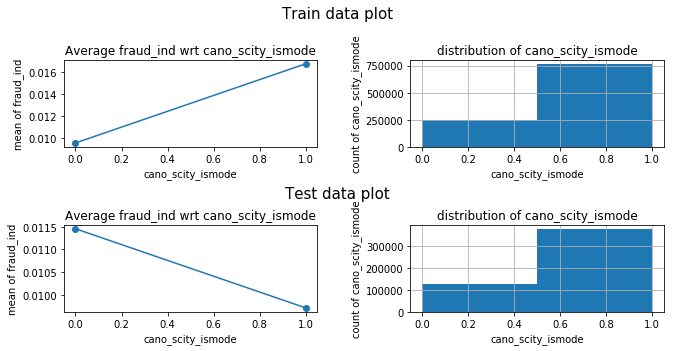

cano_csmcu_ismode


<Figure size 432x288 with 0 Axes>

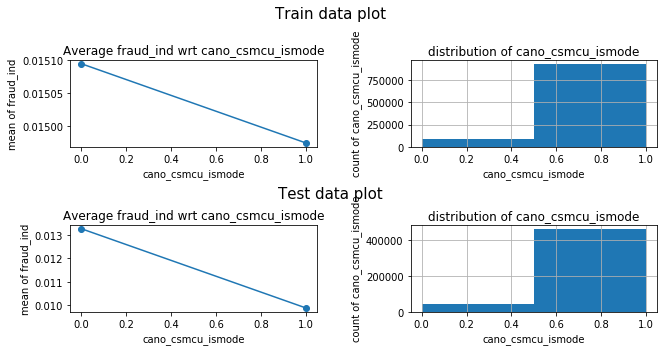

mchno_fraud_mean


<Figure size 432x288 with 0 Axes>

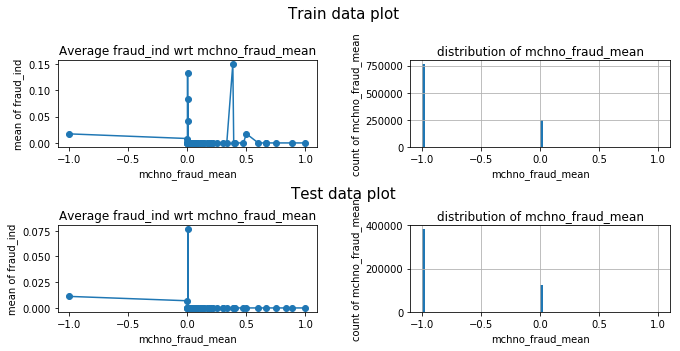

mcc_fraud_mean


<Figure size 432x288 with 0 Axes>

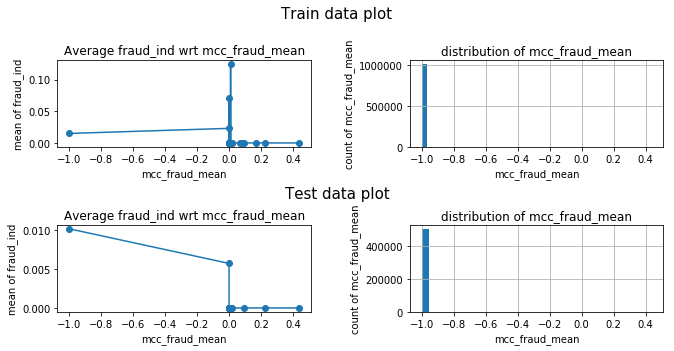

acqic_fraud_mean


<Figure size 432x288 with 0 Axes>

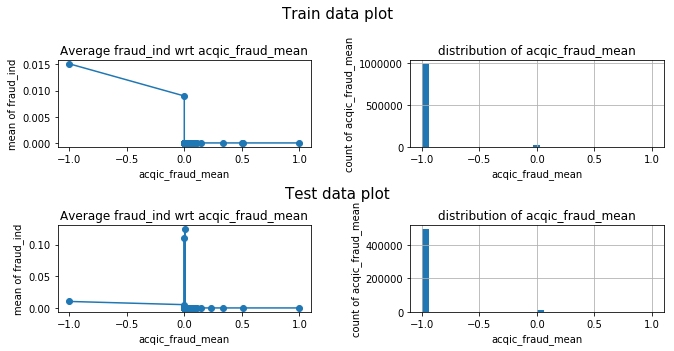

mchno_bacno_nunique


<Figure size 432x288 with 0 Axes>

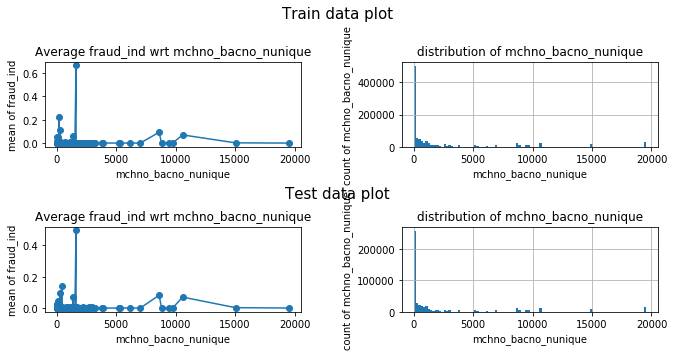

acqic_bacno_nunique


<Figure size 432x288 with 0 Axes>

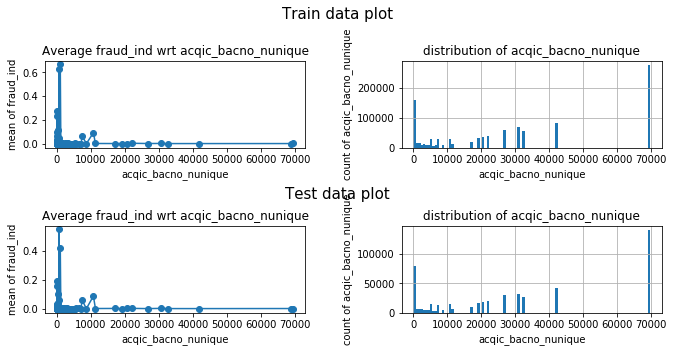

mcc_bacno_nunique


<Figure size 432x288 with 0 Axes>

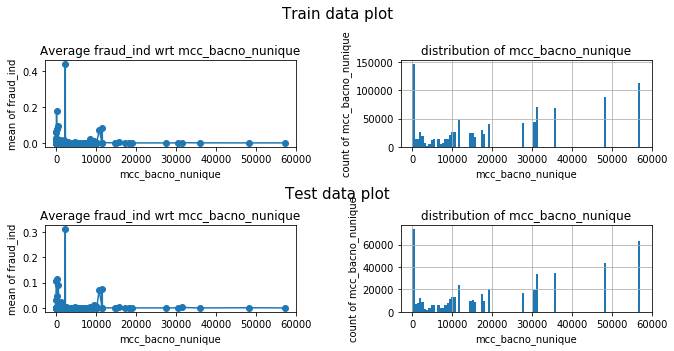

stocn_bacno_nunique


<Figure size 432x288 with 0 Axes>

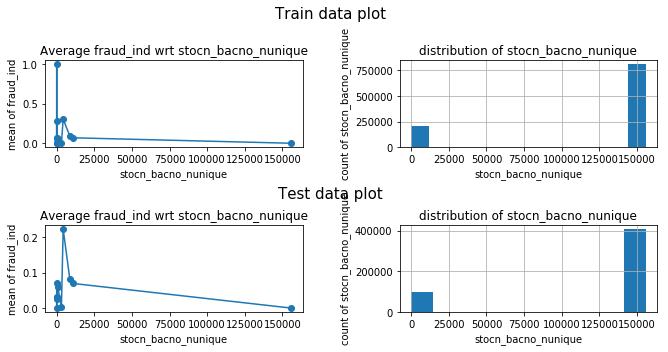

scity_bacno_nunique


<Figure size 432x288 with 0 Axes>

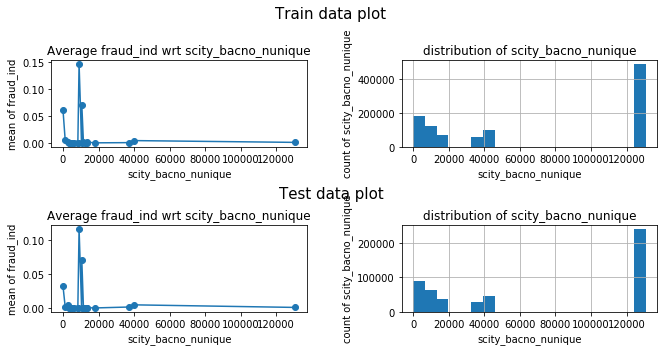

csmcu_bacno_nunique


<Figure size 432x288 with 0 Axes>

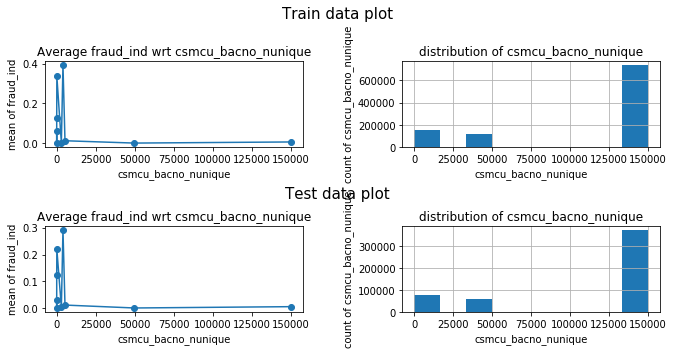

mchno_cano_nunique


<Figure size 432x288 with 0 Axes>

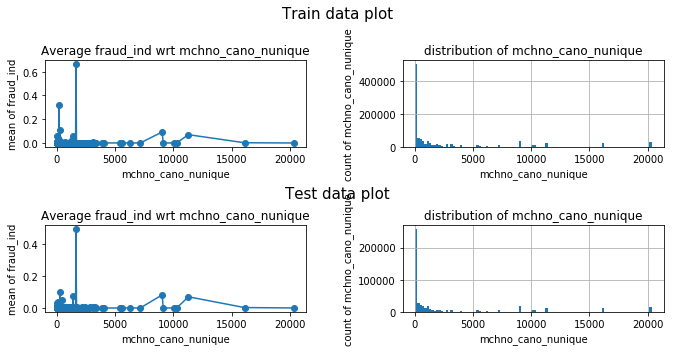

acqic_cano_nunique


<Figure size 432x288 with 0 Axes>

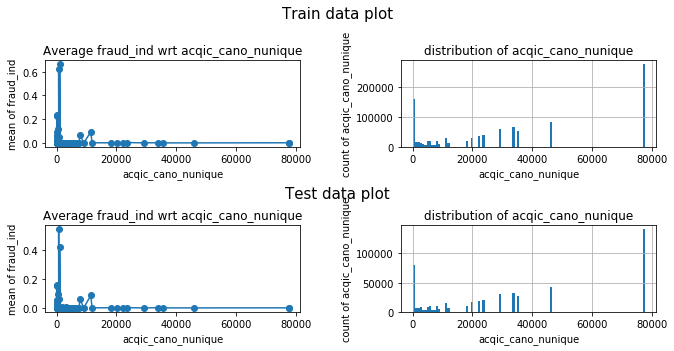

mcc_cano_nunique


<Figure size 432x288 with 0 Axes>

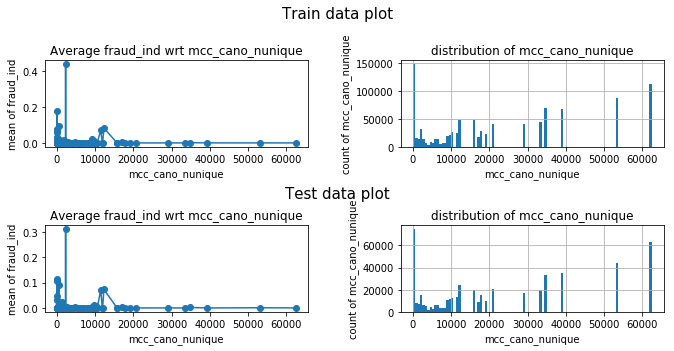

stocn_cano_nunique


<Figure size 432x288 with 0 Axes>

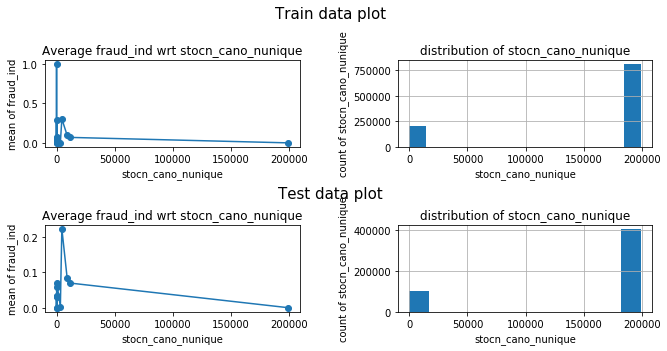

scity_cano_nunique


<Figure size 432x288 with 0 Axes>

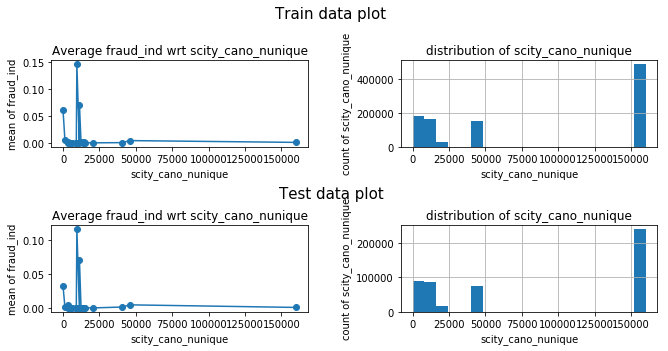

csmcu_cano_nunique


<Figure size 432x288 with 0 Axes>

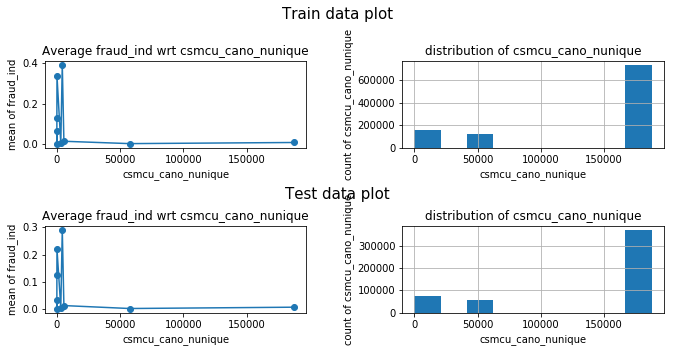

cano_lastday_use


<Figure size 432x288 with 0 Axes>

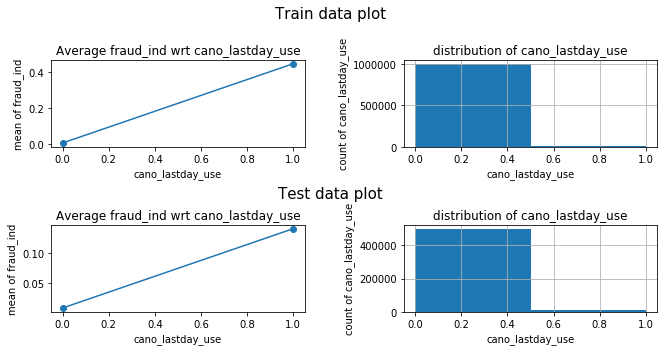

cano_hasfraud_before


<Figure size 432x288 with 0 Axes>

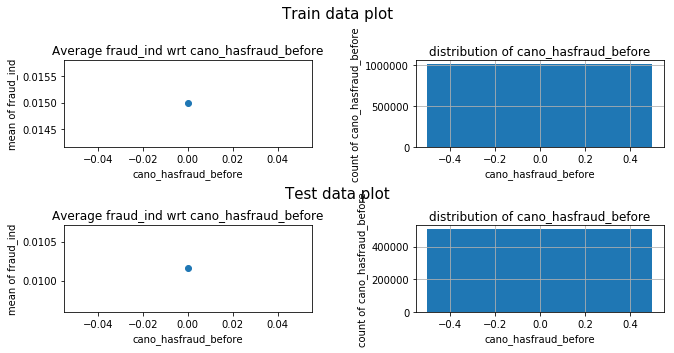

bacno_stocn_nunique


<Figure size 432x288 with 0 Axes>

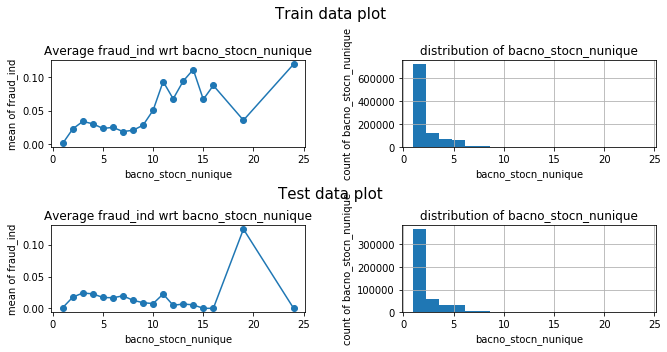

stocn_value_counts


<Figure size 432x288 with 0 Axes>

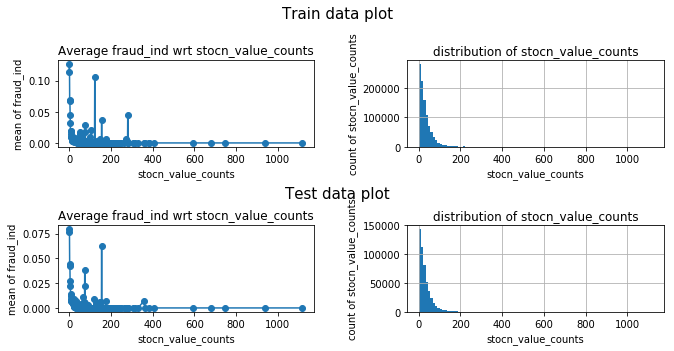

bacno_csmcu_nunique


<Figure size 432x288 with 0 Axes>

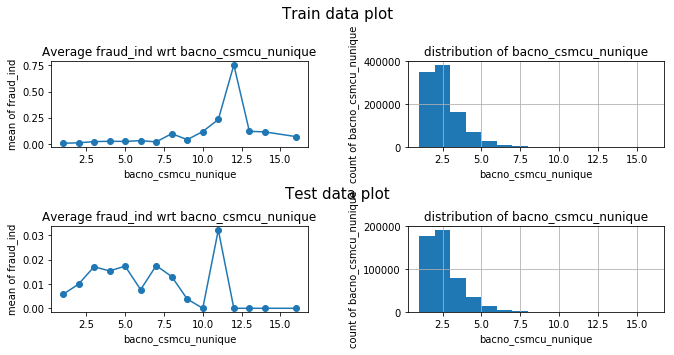

csmcu_value_counts


<Figure size 432x288 with 0 Axes>

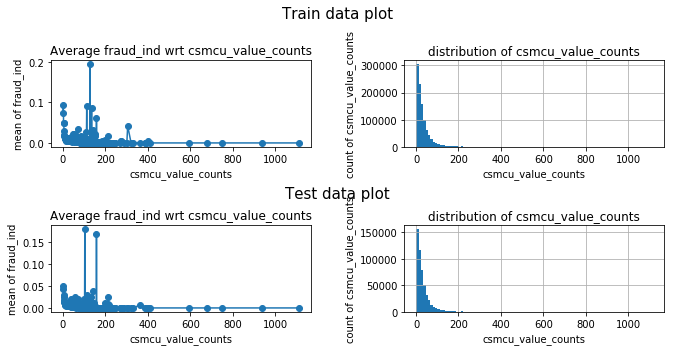

cano_only_consecutive_stscd2


<Figure size 432x288 with 0 Axes>

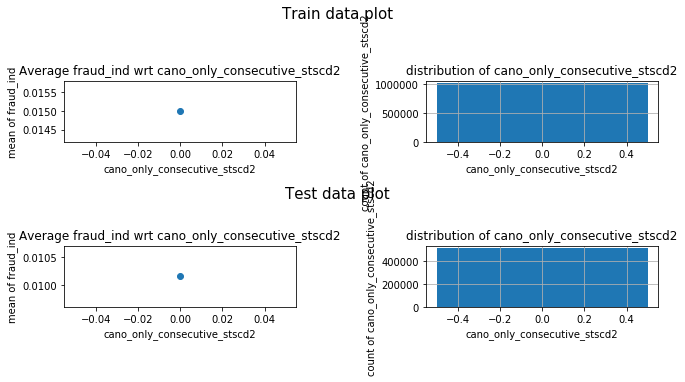

bacno_consecutive_and_only_ecfg


<Figure size 432x288 with 0 Axes>

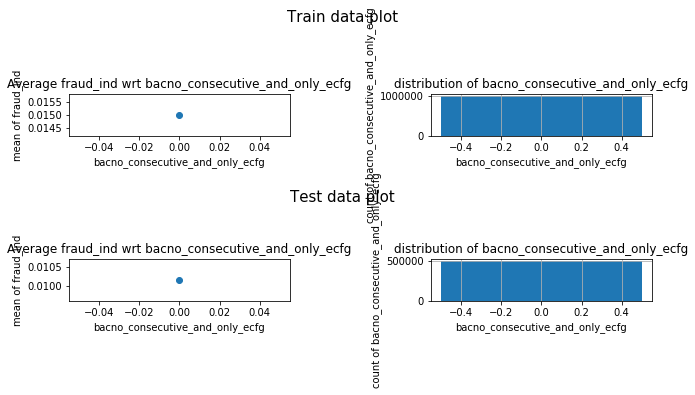

cano_lastday_use_twokind


<Figure size 432x288 with 0 Axes>

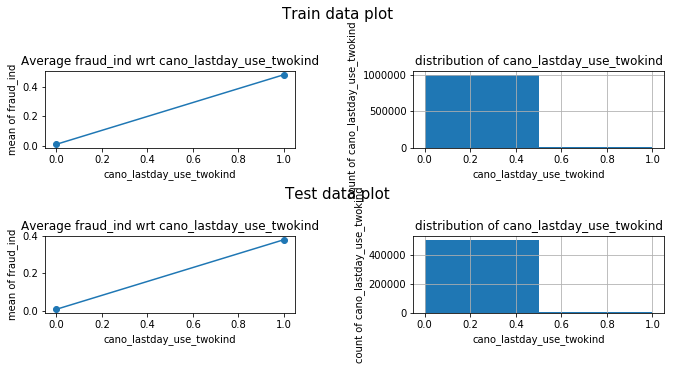

cano_lastlocdt


<Figure size 432x288 with 0 Axes>

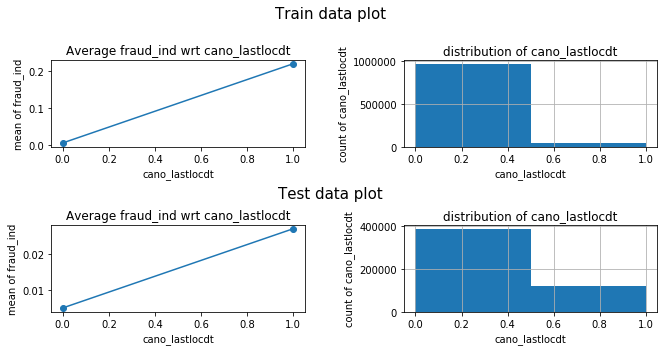

bacno_lastlocdt


<Figure size 432x288 with 0 Axes>

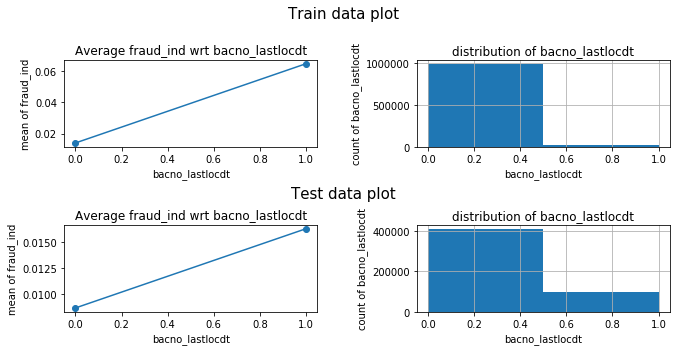

cano_lastlocdt2


<Figure size 432x288 with 0 Axes>

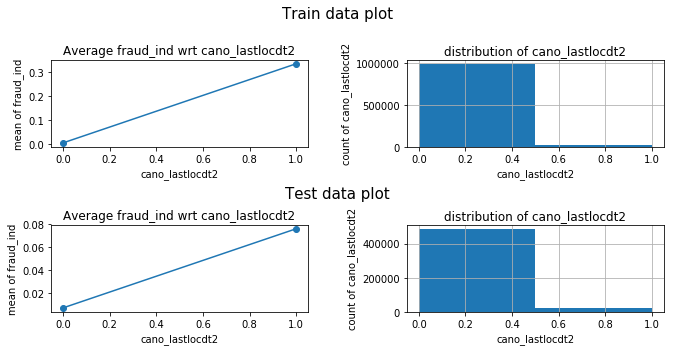

bacno_stscd_equal2


<Figure size 432x288 with 0 Axes>

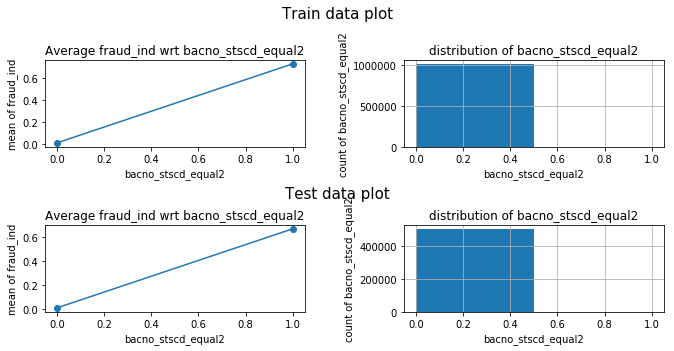

bacno_ecfg_equal1


<Figure size 432x288 with 0 Axes>

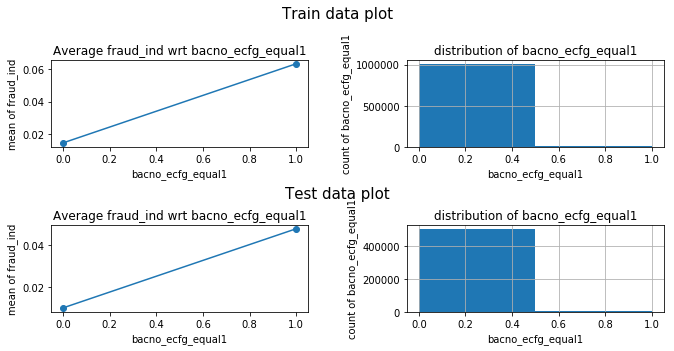

In [14]:
train_d = all_data[all_data['locdt']<=60]
valid_d = all_data[(all_data['locdt']>60)&(all_data['locdt']<=90)]
# 自己做的圖表function，畵資料分佈的bar chart和對fraud_ind的關係

for c in train_d.columns:
    analze_distribution(train_d,'fraud_ind',c,valid_d)


from featexp import get_univariate_plots
# get_univariate_plots(data=train_d, target_col='fraud_ind', features_list=['hcefg'], bins=100, data_test=valid_d)
# get_univariate_plots(data=train_d, target_col='fraud_ind', features_list=['loctm_hr'], bins=10, data_test=valid_d)
# get_univariate_plots(data=train_d, target_col='fraud_ind', features_list=['flg_3dsmk'], bins=10, data_test=valid_d)
# get_univariate_plots(data=train_d, target_col='fraud_ind', features_list=['csmcu'], bins=100, data_test=valid_d)

## 檢查train和test data的分佈有哪裡不一樣

In [15]:
def compare_distribution(train_data,test_data,target_name):
    target = train_data[target_name]
    target2 = test_data[target_name]
    print(target_name)
    print('nunique train',target.nunique())
    print('nunique test',target2.nunique())
    print('max train',target.max())
    print('max test',target2.max())

    fig, axs = plt.subplots(1,2,figsize=(10,3))
    
    bins = target.nunique() if target.nunique()<100 else 100
    target.hist(bins=bins,ax=axs[0])
    
    bins = target2.nunique() if target2.nunique()<100 else 100
    target2.hist(bins=bins,ax=axs[1])
    plt.show()


# for c in all_data.drop(columns='fraud_ind'):
#     compare_distribution(all_data[all_data['locdt']<=90].drop(columns='fraud_ind'),all_data[all_data['locdt']>90].drop(columns='fraud_ind'),c)

## fraud資料和normal資料的各個特徵差異

In [16]:
normal_data = all_data[all_data['fraud_ind']==0]
fraud_data = all_data[all_data['fraud_ind']==1]

# for c in normal_data.columns:
#     print(c)
#     plt.clf()
#     fig, axs = plt.subplots(1,2,figsize=(10,3))

#     bins = normal_data[c].nunique() if normal_data[c].nunique()<100 else 100
#     normal_data[c].hist(bins=bins,ax=axs[0])
#     axs[0].set_title('Normal data')
#     bins = fraud_data[c].nunique() if fraud_data[c].nunique()<100 else 100
#     fraud_data[c].hist(bins=bins,ax=axs[1])
#     axs[1].set_title('Fraud data')
#     plt.show()


## 觀察large category的feature是否有很多種bacno的fraud

In [17]:
# mchno_bacno_count = all_data.groupby('mchno').apply(lambda s:s[s['fraud_ind']==1]['bacno'].nunique())
# acqic_bacno_count = all_data.groupby('acqic').apply(lambda s:s[s['fraud_ind']==1]['bacno'].nunique())
# mcc_bacno_count = all_data.groupby('mcc').apply(lambda s:s[s['fraud_ind']==1]['bacno'].nunique())

# print(mchno_bacno_count.sum())
# print(mchno_bacno_count[mchno_bacno_count>1].sort_values())

# print(acqic_bacno_count.sum())
# print(acqic_bacno_count[acqic_bacno_count>1].sort_values())

# print(mcc_bacno_count.sum())
# print(mcc_bacno_count[mcc_bacno_count>1].sort_values())

## 以每個bacno來看fraud情況
* 找出使用者被盜刷卡時，和一般的交易差在哪裡


In [19]:
bacno_fraud_count = all_data.groupby('bacno').apply(lambda s:s[s['fraud_ind']==1]['bacno'].shape[0])

In [ ]:
print('All fraud instance',all_data.fraud_ind.sum(skipna=True))
print('{} different bacno'.format(bacno_fraud_count[bacno_fraud_count>0].shape[0]))

bacno_fraud_count[(bacno_fraud_count<10)&(bacno_fraud_count>0)].hist(bins=9)
plt.show()
plt.clf()
bacno_fraud_count[(bacno_fraud_count>0)].hist(bins=100)

## 幾乎都只被騙過一兩次

In [ ]:
list1=['locdt','cano','etymd','mchno','acqic','mcc','stocn','conam','fraud_ind']
list2=['locdt','conam','cano','ecfg','stscd','stocn','mchno','fraud_ind']
list3=['locdt','conam','cano','stocn','scity','flbmk','csmcu','ecfg','fraud_ind']
list4=['locdt','cano','mcc','etymd','stocn','scity','csmcu','fraud_ind']
# 
# ,'ecfg','etymd'
bacno_10fraud_more_list = bacno_fraud_count[(bacno_fraud_count==1)].index
pd.set_option('display.max_rows', 1000)
# print(x)
# pd.reset_option('display.max_rows')

cnt=0
for b in bacno_10fraud_more_list:
    cnt+=1
    if cnt>300:
        break
    print()
    
    print(b,all_data[all_data['bacno']==b]['fraud_ind'].sum())
    if all_data[all_data['bacno']==b]['ecfg'].sum()>=0:
        print(all_data[all_data['bacno']==b][list2].sort_values(by=['locdt']))
        
#     print(all_data[all_data['bacno']==b][list4].sort_values(by=['locdt']))

In [ ]:
list1=['locdt','cano','etymd','mchno','acqic','mcc','stocn','conam','fraud_ind']
list2=['locdt','conam','cano','ecfg','stscd','stocn','mchno','fraud_ind']
# 
# ,'ecfg'
bacno_10fraud_more_list = bacno_fraud_count[(bacno_fraud_count>=10)].index
pd.set_option('display.max_rows', 1000)
# print(x)
# pd.reset_option('display.max_rows')

cnt=0
for b in bacno_10fraud_more_list:
    cnt+=1
    if cnt>100:
        break
    print()
    
    print(b,all_data[all_data['bacno']==b]['fraud_ind'].sum())
    print(all_data[all_data['bacno']==b][list2].sort_values(by=['locdt']))

曾經在該國被盜刷的紀錄
曾經在該mchno被盜刷的紀錄
曾經在該mchno被盜刷
最後一筆是不是盜刷


### 檢查在test data中,新出現的類別有多少
bacno, mchno, acqic, mcc, stocn, scity, csmcu 

In [ ]:
def find_new_category(x,target_name):
    x_train = x[x['locdt']<=90][target_name].unique()
    x_test = x[x['locdt']>90][target_name].unique()
    
    print(target_name)
    print('{} categories in Training data:'.format(x_train.shape[0]))
    print('{} categories in Testing data:'.format(x_test.shape[0]))

    x_new_test=[]
    for b in x_test:
        if b not in x_train:
            x_new_test.append(b)

    print('{} new categories'.format(len(x_new_test)))    

In [ ]:
## 幾乎所有在test data的都是新用戶 乾
## 所以重點特徵工程不能使用用戶過去的fraud記錄
find_new_category(all_data,'bacno')

## 幾乎都太多只出現在test data上的新類別,這樣得轉換可以用來訓練(TODO)
find_new_category(all_data,'mchno')
find_new_category(all_data,'acqic')
find_new_category(all_data,'mcc')
find_new_category(all_data,'stocn')
find_new_category(all_data,'scity')
find_new_category(all_data,'csmcu')
